In [1]:
import metaworld
import torch.nn as nn
import copy
import torch
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
import torch.optim as optim
import numpy as np

/home/raju/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class critic(nn.Module):
    def __init__(self,state_space,action_space):
        super(critic,self).__init__()
        self.fc1= nn.GRU(state_space,512,32,batch_first=True)
        self.fc2= nn.Linear(512,128)
        self.fc3= nn.Linear(128,action_space)
    def forward(self,x,hidden):
        x,h= self.fc1(x)
        #x= torch.sigmoid(x)
        x= torch.tanh(self.fc2(x))
        x= torch.tanh(self.fc3(x))
        return torch.squeeze(x,-1)

In [4]:
class ActorCritic(nn.Module):
    def __init__(self,state_space,action_space,max_action):
        super(ActorCritic,self).__init__()
        self.action_space= action_space
        self.max_action= max_action
        self.fc1= nn.GRU(state_space,512,32,batch_first= True)
        self.fc2= nn.Linear(512,128)
        self.actor= nn.Linear(128,action_space)
        self.critic=critic(state_space,1).to(device)
    def forward(self,x,hidden):
        x,h= self.fc1(x,hidden)
        #x= torch.sigmoid(x)
        x= torch.tanh(self.fc2(x))
        #x= torch.tanh(self.actor(x))
        return x, h
    def step(self,obs,hidden):
        with torch.no_grad():
            p,h= self.forward(obs,hidden)
            action_mean,_= self.act(obs,hidden)
            cov_mat = torch.eye(self.action_space).to(device)
            dist= MultivariateNormal(action_mean,cov_mat)
            action= dist.sample()
            log_p= dist.log_prob(action).sum(axis=-1)
            v= self.critic(obs,hidden)
        return action.cpu().numpy(),v.cpu().numpy(), log_p.cpu().numpy(),h
    def act(self, state, hidden):
        p, h = self.forward(state, hidden.contiguous())
        #print(p.shape)
        action = torch.tanh(self.actor(p))
        return action * self.max_action, h
    def logp(self,obs,act,hidden):
        action_mean,_= self.act(obs,hidden)
        cov_mat = torch.eye(self.action_space).to(device)
        dist= MultivariateNormal(action_mean,cov_mat)
        #action= dist.sample().to(device)
        log_p= dist.log_prob(act).sum(axis=-1)
        return log_p

In [5]:
import random
ml10 = metaworld.ML10() # Construct the benchmark, sampling tasks

training_envs = []
for name, env_cls in ml10.train_classes.items():
  env = env_cls()
  task = random.choice([task for task in ml10.train_tasks
                        if task.env_name == name])
  env.set_task(task)
  training_envs.append(env)

for env in training_envs:
  obs = env.reset()  # Reset environment
  a = env.action_space.sample()  # Sample an action
  obs, reward, done, info = env.step(a) 

/home/raju/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [6]:
training_envs

In [7]:
actor_critic= ActorCritic(env.observation_space.shape[0]+env.action_space.shape[0]+2,env.action_space.shape[0],1).to(device)

In [8]:
ac_optimizer=optim.Adam(actor_critic.parameters(),lr=1e-3)
critic_optimizer= optim.Adam(actor_critic.critic.parameters(),lr=1e-3)
criterion= nn.MSELoss()

In [9]:
def reward_to_go(rews):
    n = len(rews)
    rtgs = np.zeros_like(rews.cpu())
    for i in reversed(range(n)):
        rtgs[i] = rews[i] + (rtgs[i+1] if i+1 < n else 0)
    return  rtgs

In [10]:
def update(state_batch,reward_batch,action_batch,v_batch,log_prob_batch,advantage_batch,hidden_batch):
    clip_ratio=0.2
    l=[]
    state_batch= np.asarray(state_batch)
    state_batch= torch.FloatTensor(state_batch).to(device).unsqueeze(1)
    reward_batch= torch.as_tensor(reward_batch,dtype= torch.float32).to(device)
    hidden_batch= torch.stack(hidden_batch).squeeze(2).contiguous()
    #print(hidden_batch.shape)
    hidden_batch= hidden_batch.transpose(0,1).to(device)
    action_batch= torch.as_tensor(np.asarray(action_batch),dtype= torch.int32).to(device)
    v_batch= torch.as_tensor(np.asarray(v_batch),dtype= torch.int32).to(device)
    log_prob_old= torch.as_tensor(np.asarray(log_prob_batch), dtype= torch.float32).to(device)
    advantage= torch.as_tensor(np.asarray(advantage_batch), dtype= torch.float32).to(device)
    rtgs= torch.as_tensor(reward_to_go(reward_batch)).to(device)
    for i in range(32):
        log_prob= actor_critic.logp(state_batch,action_batch,hidden_batch)
        ratio= torch.exp(log_prob-log_prob_old)
        clip_adv = torch.clamp(ratio, 1-clip_ratio, 1+clip_ratio) * advantage
        loss_pi = -(torch.min(ratio * advantage, clip_adv)).mean()

        ac_optimizer.zero_grad()
        loss_pi.backward()
        ac_optimizer.step()

        #loss_v= ((actor_critic.critic(state_batch,hidden_batch) - rtgs)**2).mean()
        loss_v= criterion(actor_critic.critic(state_batch,hidden_batch).reshape(500),rtgs)
        critic_optimizer.zero_grad()
        loss_v.backward()
        critic_optimizer.step()
    l.append(loss_v)

In [11]:
def gae(gamma,lambd,v_old,v_new,r,d):
    batch_size=len(d)
    advantage = np.zeros(batch_size + 1)
    for t in reversed(range(batch_size)):
        delta = r[t] + (gamma * v_new[t] ) - v_old[t]
        advantage[t] = delta + (gamma * lambd * advantage[t + 1]) 
    return advantage[:batch_size]

In [ ]:
en_r=[]
env_su=[]
torch.cuda.empty_cache()
for env in training_envs:
    r_l=[]
    sucess=[]
    print(env)
    #env= random.choice(training_envs)
    h0= torch.randn((actor_critic.fc1.num_layers,1,actor_critic.fc1.hidden_size)).to(device)
    for epoch in range(2500):
        state_batch=[]
        reward_batch=[]
        action_batch=[]
        v_batch=[]
        v_new_batch=[]
        log_prob_batch=[]
        terminal_batch=[]
        advantage_batch=[]
        rewards=[]
        obs_batch=[]
        hidden_batch=[]
        state= env.reset()
        action= env.action_space.sample()
        next_s,reward,done,info= env.step(action)
        obs= np.concatenate((next_s,action,[reward],[info['success']]))
        obs= torch.FloatTensor(obs.reshape(1, -1)).to(device)[:, None, :]
        r=0
        c=0
        for i in range(500):
            #env.render()
            a,v_old,log_p,h= actor_critic.step(obs,h0)
            #print(a[0][0])
            next_s, reward,done,info=env.step(a[0][0])
            obs= np.concatenate((next_s,action,[reward],[info['success']]))
            state_batch.append(obs)
            reward_batch.append(reward)
            action_batch.append(a[0][0])
            v_batch.append(v_old)
            log_prob_batch.append(log_p)
            terminal_batch.append(info['success'])
            hidden_batch.append(h.cpu())
            obs= torch.FloatTensor(obs.reshape(1, -1)).to(device)[:, None, :]
            _,v_new,log_p,_=actor_critic.step(obs,h0)
            v_new_batch.append(v_new)
            #adv= (reward+0.99*v_new)-v_old
            #advantage_batch.append(adv)
            state=next_s
            h0=h          
            r+=reward
            c+=info['success']
        sucess.append(c)
        advantage_batch=gae(0.9,0.95,v_batch,v_new_batch,reward_batch,terminal_batch)
        h0=h0
        r_l.append(r)
        update(state_batch,reward_batch,action_batch,v_batch,log_prob_batch,advantage_batch,hidden_batch)
        if epoch%25 == 24:
            print("Episode: ",epoch," Last avg reward: ",sum(r_l[-25:])/25)
            print('Success rate:',sum(sucess[-25:])/(25*500))
    en_r.append(r_l)
    env_su.append(sucess)

<SawyerReachEnvV2 instance>
Episode:  24  Last avg reward:  529.5780845847484
Success rate: 0.0
Episode:  49  Last avg reward:  386.2465046318542
Success rate: 0.0
Episode:  74  Last avg reward:  391.4718501145764
Success rate: 0.0
Episode:  99  Last avg reward:  427.7682779470265
Success rate: 0.0
Episode:  124  Last avg reward:  446.17944872558496
Success rate: 0.0
Episode:  149  Last avg reward:  503.36841853973675
Success rate: 0.0
Episode:  174  Last avg reward:  492.885314677239
Success rate: 0.00056
Episode:  199  Last avg reward:  493.06545333265393
Success rate: 0.0
Episode:  224  Last avg reward:  496.3102088153397
Success rate: 0.0
Episode:  249  Last avg reward:  452.9865708933028
Success rate: 0.0
Episode:  274  Last avg reward:  442.5153597025182
Success rate: 0.0
Episode:  299  Last avg reward:  450.39728160561594
Success rate: 0.0
Episode:  324  Last avg reward:  392.793539714277
Success rate: 0.0
Episode:  349  Last avg reward:  521.6364874228308
Success rate: 0.00744


Text(0, 0.5, 'Reward')

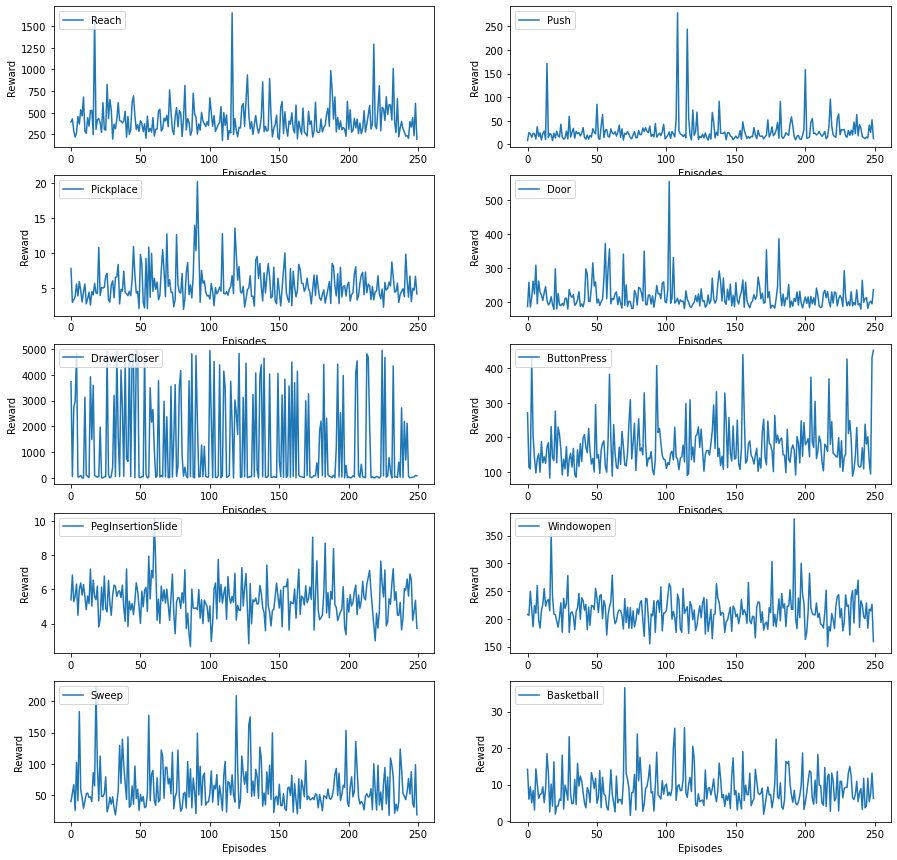

In [23]:
import matplotlib.pyplot as plt
env1=['Reach','Push','Pickplace','Door','DrawerCloser','ButtonPress','PegInsertionSlide','Windowopen','Sweep','Basketball']
plt.figure(figsize=(15,15))
plt.subplot(5,2,1)
plt.plot(en_r[0],label= env1[0])
plt.legend(loc= 'upper left')
plt.xlabel('Episodes')
plt.ylabel("Reward")
plt.subplot(5,2,2)
plt.plot(en_r[1],label= env1[1])
plt.legend(loc= 'upper left')
plt.xlabel('Episodes')
plt.ylabel("Reward")
plt.subplot(5,2,3)
plt.plot(en_r[2],label= env1[2])
plt.legend(loc= 'upper left')
plt.xlabel('Episodes')
plt.ylabel("Reward")
plt.subplot(5,2,4)
plt.plot(en_r[3],label= env1[3])
plt.legend(loc= 'upper left')
plt.xlabel('Episodes')
plt.ylabel("Reward")
plt.subplot(5,2,5)
plt.plot(en_r[4],label= env1[4])
plt.legend(loc= 'upper left')
plt.xlabel('Episodes')
plt.ylabel("Reward")
plt.subplot(5,2,6)
plt.plot(en_r[5],label= env1[5])
plt.legend(loc= 'upper left')
plt.xlabel('Episodes')
plt.ylabel("Reward")
plt.subplot(5,2,7)
plt.plot(en_r[6],label= env1[6])
plt.legend(loc= 'upper left')
plt.xlabel('Episodes')
plt.ylabel("Reward")
plt.subplot(5,2,8)
plt.plot(en_r[7],label= env1[7])
plt.legend(loc= 'upper left')
plt.xlabel('Episodes')
plt.ylabel("Reward")
plt.subplot(5,2,9)
plt.plot(en_r[8],label= env1[8])
plt.legend(loc= 'upper left')
plt.xlabel('Episodes')
plt.ylabel("Reward")
plt.subplot(5,2,10)
plt.plot(en_r[9],label= env1[9])
plt.legend(loc= 'upper left')
plt.xlabel('Episodes')
plt.ylabel("Reward")

In [26]:
testing_envs = []
for name, env_cls in ml10.test_classes.items():
  env = env_cls()
  task = random.choice([task for task in ml10.test_tasks
                        if task.env_name == name])
  env.set_task(task)
  testing_envs.append(env)

/home/raju/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [27]:
ent_r=[]
envt_su=[]
torch.cuda.empty_cache()
for env in testing_envs:
    r_l=[]
    sucess=[]
    print(env)
    #env= random.choice(training_envs)
    h0= torch.randn((actor_critic.fc1.num_layers,1,actor_critic.fc1.hidden_size)).to(device)
    for epoch in range(20):
        state_batch=[]
        reward_batch=[]
        action_batch=[]
        v_batch=[]
        v_new_batch=[]
        log_prob_batch=[]
        terminal_batch=[]
        advantage_batch=[]
        rewards=[]
        obs_batch=[]
        hidden_batch=[]
        state= env.reset()
        action= env.action_space.sample()
        next_s,reward,done,info= env.step(action)
        obs= np.concatenate((next_s,action,[reward],[info['success']]))
        obs= torch.FloatTensor(obs.reshape(1, -1)).to(device)[:, None, :]
        r=0
        c=0
        for i in range(500):
            env.render()
            a,v_old,log_p,h= actor_critic.step(obs,h0)
            #print(a[0][0])
            next_s, reward,done,info=env.step(a[0][0])
            obs= np.concatenate((next_s,action,[reward],[info['success']]))
            state_batch.append(obs)
            reward_batch.append(reward)
            action_batch.append(a[0][0])
            v_batch.append(v_old)
            log_prob_batch.append(log_p)
            terminal_batch.append(info['success'])
            hidden_batch.append(h.cpu())
            obs= torch.FloatTensor(obs.reshape(1, -1)).to(device)[:, None, :]
            _,v_new,log_p,_=actor_critic.step(obs,h0)
            v_new_batch.append(v_new)
            #adv= (reward+0.99*v_new)-v_old
            #advantage_batch.append(adv)
            state=next_s
            h0=h          
            r+=reward
            c+=info['success']
        sucess.append(c)
        advantage_batch=gae(0.9,0.95,v_batch,v_new_batch,reward_batch,terminal_batch)
        h0=h0
        r_l.append(r)
        update(state_batch,reward_batch,action_batch,v_batch,log_prob_batch,advantage_batch,hidden_batch)
        if epoch%10 == 9:
            print("Episode: ",epoch," Last avg reward: ",sum(r_l[-10:])/10)
            print('Success rate:',sum(sucess[-10:])/(10*500))
    ent_r.append(r_l)
    envt_su.append(sucess)

<SawyerDrawerOpenEnvV2 instance>
Creating window glfw
Episode:  9  Last avg reward:  462.18187414730954
Success rate: 0.0
Episode:  19  Last avg reward:  557.9680940135765
Success rate: 0.0
<SawyerDoorCloseEnvV2 instance>
Creating window glfw
Episode:  9  Last avg reward:  27.289392756476268
Success rate: 0.0
Episode:  19  Last avg reward:  27.117845735068226
Success rate: 0.0
<SawyerShelfPlaceEnvV2 instance>
Creating window glfw
Episode:  9  Last avg reward:  0.0
Success rate: 0.0
Episode:  19  Last avg reward:  0.0
Success rate: 0.0
<SawyerSweepIntoGoalEnvV2 instance>
Creating window glfw
Episode:  9  Last avg reward:  46.92949303783883
Success rate: 0.0
Episode:  19  Last avg reward:  62.816875790024014
Success rate: 0.0
<SawyerLeverPullEnvV2 instance>
Creating window glfw
Episode:  9  Last avg reward:  160.71002701503463
Success rate: 0.0
Episode:  19  Last avg reward:  168.28298173354864
Success rate: 0.0


In [28]:
test_env=['DrawerOpen','DoorClose','ShelfPlace','SweepIntoGoal','LeverPull']

Text(0, 0.5, 'Reward')

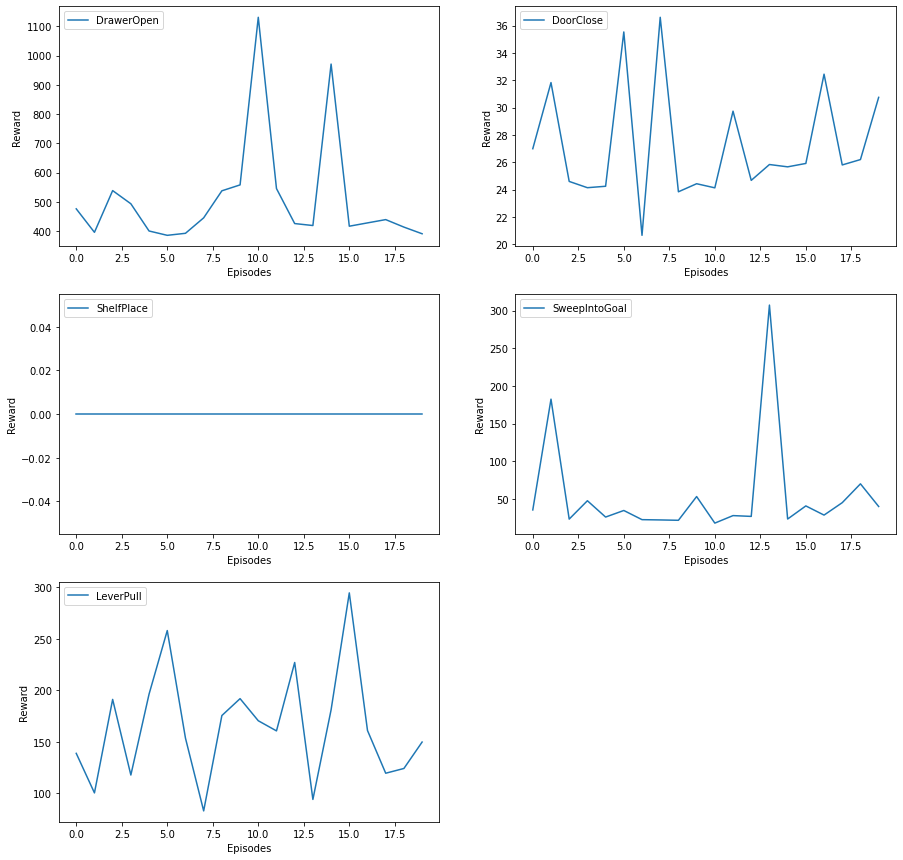

In [30]:
plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.plot(ent_r[0],label= test_env[0])
plt.legend(loc= 'upper left')
plt.xlabel('Episodes')
plt.ylabel("Reward")
plt.subplot(3,2,2)
plt.plot(ent_r[1],label= test_env[1])
plt.legend(loc= 'upper left')
plt.xlabel('Episodes')
plt.ylabel("Reward")
plt.subplot(3,2,3)
plt.plot(ent_r[2],label= test_env[2])
plt.legend(loc= 'upper left')
plt.xlabel('Episodes')
plt.ylabel("Reward")
plt.subplot(3,2,4)
plt.plot(ent_r[3],label= test_env[3])
plt.legend(loc= 'upper left')
plt.xlabel('Episodes')
plt.ylabel("Reward")
plt.subplot(3,2,5)
plt.plot(ent_r[4],label= test_env[4])
plt.legend(loc= 'upper left')
plt.xlabel('Episodes')
plt.ylabel("Reward")